In [1]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load data

In [3]:
survey_df = pd.read_csv('/content/drive/My Drive/SharedResponsesSurvey.csv')
print(f"survey_df: {survey_df.shape}")

<ipython-input-3-254367ce059d>:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_df = pd.read_csv('/content/drive/My Drive/SharedResponsesSurvey.csv')


survey_df: (11286141, 27)


In [4]:
# drop all rows with NaN values
survey_df = survey_df.dropna()
survey_df = survey_df.replace('', np.nan)
survey_df = survey_df.dropna()    # drop empty string rows
print(f"survey_df (dropped nan): {survey_df.shape}")

survey_df (dropped nan): (8833729, 27)


In [5]:
headers = survey_df.columns
print(f"Header names: {headers}")

# Randomly sample 10% examples from survey_df
sampled_df = survey_df.sample(frac=0.1, random_state=1)

print(f"sampled_df: {sampled_df.shape}")

# Once sampled_df is created, delete the original survey_df to free up System RAM
del survey_df
gc.collect()

Header names: Index(['ResponseID', 'ExtendedSessionID', 'UserID', 'ScenarioOrder',
       'Intervention', 'PedPed', 'Barrier', 'CrossingSignal', 'AttributeLevel',
       'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
       'NonDefaultChoice', 'DefaultChoiceIsOmission', 'NumberOfCharacters',
       'DiffNumberOFCharacters', 'Saved', 'Template', 'DescriptionShown',
       'LeftHand', 'UserCountry3', 'Review_age', 'Review_education',
       'Review_gender', 'Review_income', 'Review_political',
       'Review_religious'],
      dtype='object')
sampled_df: (883373, 27)


0

Perform data preprocessing

In [6]:
# Split test, valid, train datasets
target_column = ['Saved']
drop_columns = ['ResponseID', 'ExtendedSessionID', 'UserID', 'Saved', 'Template']  # remove unneeded features
encode_columns = ['AttributeLevel', 'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
                     'NonDefaultChoice', 'UserCountry3', 'Review_education', 'Review_gender', 'Review_income']  # encode to 1-hot vectors

# one_hot_encoded_df = pd.get_dummies(sampled_df[encode_columns], sparse=True)
one_hot_encoded_df = pd.get_dummies(sampled_df[encode_columns])
X = sampled_df.drop(encode_columns + drop_columns, axis=1)
X = pd.concat([X, one_hot_encoded_df], axis=1)
y = sampled_df[target_column]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

# Once X and y are loaded, delete the one_hot_encoded_df object to free up System RAM
del one_hot_encoded_df, sampled_df
gc.collect()

X: (883373, 285)
y: (883373, 1)


0

In [7]:
X.head()

,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,DefaultChoiceIsOmission,NumberOfCharacters,DiffNumberOFCharacters,DescriptionShown,LeftHand,...,Review_income_15000,Review_income_25000,Review_income_35000,Review_income_5000,Review_income_50000,Review_income_80000,Review_income_above100000,Review_income_default,Review_income_over10000,Review_income_under5000
9465311,6,1,0,1,0,0.0,2,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
10462302,3,1,0,1,0,1.0,1,0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
6201309,11,1,1,0,0,1.0,2,0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2780663,6,0,0,1,0,0.0,5,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1111090,3,0,0,1,0,1.0,4,0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
y.head()

,Saved
9465311,1
10462302,0
6201309,0
2780663,1
1111090,1


Prepare data for model training

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train.to_numpy(dtype=np.float32))
y_train = torch.tensor(y_train.to_numpy(dtype=np.float32).reshape(-1, 1))  # Reshape for consistency
X_val = torch.tensor(X_val.to_numpy(dtype=np.float32))
y_val = torch.tensor(y_val.to_numpy(dtype=np.float32).reshape(-1, 1))
X_test = torch.tensor(X_test.to_numpy(dtype=np.float32))
y_test = torch.tensor(y_test.to_numpy(dtype=np.float32).reshape(-1, 1))

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Create Dataset objects
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/managers.py:1835: RuntimeWarning: overflow encountered in cast
  result[rl.indexer] = arr


X_train: torch.Size([530023, 285])
y_train: torch.Size([530023, 1])
X_val: torch.Size([176675, 285])
y_val: torch.Size([176675, 1])
X_test: torch.Size([176675, 285])
y_test: torch.Size([176675, 1])


Create model

In [10]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x

In [11]:
input_size = X_train.shape[1]
model = BinaryClassifier(input_size)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training loop

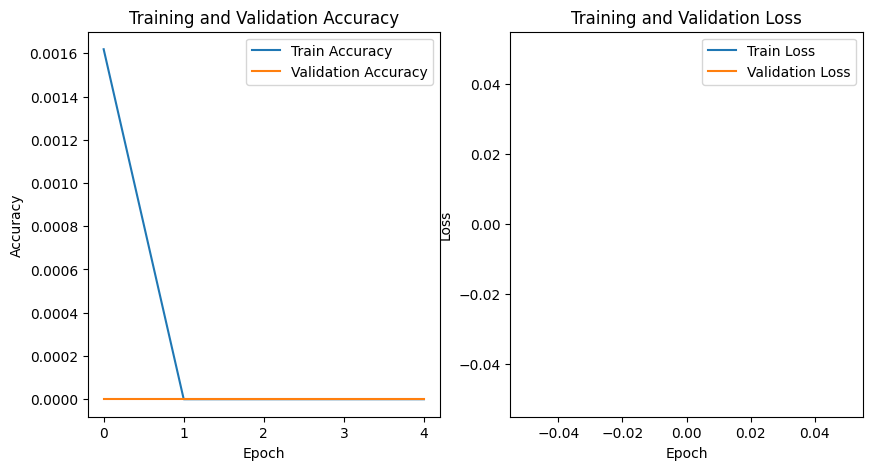

Epoch [5/50], Train Loss: nan, Train Accuracy: 0.0000, Validation Loss: nan, Validation Accuracy: 0.0000


KeyboardInterrupt: 

In [12]:
epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.sigmoid(outputs).round()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = torch.sigmoid(outputs).round()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_losses.append(running_loss / len(val_loader))
    val_accuracies.append(correct / total)

    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

In [ ]:
# Save the model state
model_save_path = '/content/drive/My Drive/cog403_model.pth'
torch.save(model.state_dict(), model_save_path)

Evaluate on test set

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_loss += loss.item()
        predicted = torch.sigmoid(outputs).round()
        correct += (predicted == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

Experiment 1

In [ ]:
# TODO